# Dependencies

In [1]:
import os, warnings, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 160)

In [2]:
# Preprocess data
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()\

# Preprocess inputs
CLS = 0
PAD = 1
SEP = 2

def preprocess_roberta(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][:max_seq_len]
    attention_mask = encoded['attention_mask'][:max_seq_len]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def preprocess_roberta_tail(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def get_data(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    y_data_int = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])

        y_data.append(getattr(row, 'toxic'))
        y_data_int.append(getattr(row, 'toxic_int'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = [np.asarray(y_data, dtype=np.float32), 
              np.asarray(y_data_int, dtype=np.int8)]
    
    return x_data, y_data
    
def get_data_valid(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])

        y_data.append(getattr(row, 'toxic'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = np.asarray(y_data, dtype=np.int8)
    
    return x_data, y_data

def get_data_test(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])


    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    return x_data

# Parameters

In [3]:
MAX_LEN = 128
tokenizer_path = 'jplu/tf-xlm-roberta-large'
sample_rate = 2

# Load data

In [4]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

n_neg_samp_df1 = len(train1.query('toxic > .5')) * sample_rate
n_neg_samp_df2 = len(train2.query('toxic > .5')) * sample_rate

train_df = pd.concat([train1[['comment_text', 'toxic']].query('toxic > .5'),
                      train1[['comment_text', 'toxic']].query('toxic <= .5').sample(n=n_neg_samp_df1, random_state=SEED),
                      train2[['comment_text', 'toxic']].query('toxic > .5'),
                      train2[['comment_text', 'toxic']].query('toxic <= .5').sample(n=n_neg_samp_df2, random_state=SEED)
                    ])
train_df['toxic_int'] = train_df['toxic'].round().astype(int)

print(f'Dataframe 1 samples: toxic|non-toxic | {n_neg_samp_df1 // sample_rate}|{n_neg_samp_df1}')
print(f'Dataframe 2 samples: toxic|non-toxic | {n_neg_samp_df2 // sample_rate}|{n_neg_samp_df2}')
print('Train samples %d' % len(train_df))
display(train_df.head())

Dataframe 1 samples: toxic|non-toxic | 21384|42768
Dataframe 2 samples: toxic|non-toxic | 112226|224452
Train samples 400830


,comment_text,toxic,toxic_int
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0,1
12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any on...",1.0,1
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1.0,1
42,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holoc...",1.0,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1.0,1


# Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, lowercase=False)

## Preprocess

In [6]:
train_df['comment_text'] = train_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
train_df['length'] = train_df['comment_text'].apply(lambda x : len(x))
train_df['word_count'] = train_df['comment_text'].apply(lambda x : len(x.split(' ')))
train_df['token_count'] = train_df['comment_text'].apply(lambda x : len(tokenizer.encode(x)))

print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples 400830


,comment_text,toxic,toxic_int,length,word_count,token_count
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0,1,44,8,19
12,"Hey... what is it.. @ | talk . What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one ...",1.0,1,318,53,95
16,"Bye! Don't look, come or think of comming back! Tosser.",1.0,1,55,10,21
42,"You are gay or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two ways, why you do erased my comment about WW, that holocaust was br...",1.0,1,633,114,187
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1.0,1,40,8,18


,toxic,toxic_int,length,word_count,token_count
count,400830.000000,400830.000000,400830.000000,400830.000000,400830.000000
mean,0.289194,0.333333,290.604635,51.032717,73.644742
std,0.356484,0.471405,331.648552,57.525157,86.714421
min,0.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,0.000000,88.000000,16.000000,25.000000
50%,0.000000,0.000000,186.000000,33.000000,49.000000
75%,0.600000,1.000000,380.000000,67.000000,95.000000
max,1.000000,1.000000,5000.000000,2321.000000,2783.000000


## Filter

In [7]:
train_df = train_df[train_df['word_count'] <= 250]
train_df = train_df[train_df['token_count'] <= 1000]
train_df = shuffle(train_df, random_state=SEED).reset_index(drop=True)

print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples 398350


,comment_text,toxic,toxic_int,length,word_count,token_count
0,If someone's 'short-circuiting' mentally speaking they do uncharacteristic things. I witnessed this with my Uncle Robert. Bob as everyone called him embezzl...,0.0,0,588,97,148
1,Oh Willy!! You took his bait! Ignore trolls like that.,1.0,1,54,10,19
2,"What are you talking about, and why do you have to do it anonymously? Do you have any source for your claim that union money is spent in the millions to inf...",0.0,0,177,34,40
3,"Ohh, and Pennsylvania is down .% since in terms of manufacturing jobs, their losses have been much more gradual but without the recovery Michigan has seen.",0.0,0,155,26,35
4,The consumer will end up paying more if this corporate tax passes. What will the State do with the money ? Waste the money on social programs that will do n...,0.0,0,341,62,71


,toxic,toxic_int,length,word_count,token_count
count,398350.000000,398350.000000,398350.000000,398350.000000,398350.000000
mean,0.289436,0.333850,275.658953,48.483351,69.580402
std,0.355942,0.471587,257.945199,44.800353,61.822629
min,0.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,0.000000,87.000000,16.000000,25.000000
50%,0.000000,0.000000,185.000000,33.000000,48.000000
75%,0.600000,1.000000,375.000000,66.000000,93.000000
max,1.000000,1.000000,4973.000000,250.000000,953.000000


# Data generation sanity check

In [8]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 22
    comment_text = train_df['comment_text'].loc[idx]
    
    x_train, y_train = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta)
    
    print('label         : "%.4f"' % y_train[0])
    print('label int     : "%d"'   % y_train[1])
    print('comment_text  : "%s"'   % comment_text)
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    
    print('-------------------- TAIL --------------------')
    x_train, _ = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta_tail)
    
    print('input_ids     : "%s"' % x_train[0][0])
    print('attention_mask: "%s"' % x_train[1][0])
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len


Row 0
label         : "0.0000"
label int     : "0"
comment_text  : "If someone's 'short-circuiting' mentally speaking they do uncharacteristic things. I witnessed this with my Uncle Robert. Bob as everyone called him embezzled thousands of dollars from a mortuary where he worked. Not only did he stiff the business owner (no pun intended), but he wasted this money on frivolous gambling trips to Vegas. The one good thing I can say about Hillary, is she seems to have wisely invested monies she garnered through illicit State Department deals. I personally don't think her brain is totally shot. The 'crookedness' part of it seems to be working just fine!"
input_ids     : "[     0   4263  22008     25      7    242 186500      9  82063   7143
    214     25  13893    538 142146   1836     54     51   9254   2263
    720      2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"
-------------------- TAIL --------------------
input_ids     : "[     0 112668  51876      5    581  

# 5-Fold split

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['toxic_int'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 318680, Validation size 79670
Fold: 2, Train size: 318680, Validation size 79670
Fold: 3, Train size: 318680, Validation size 79670
Fold: 4, Train size: 318680, Validation size 79670
Fold: 5, Train size: 318680, Validation size 79670


# Label distribution

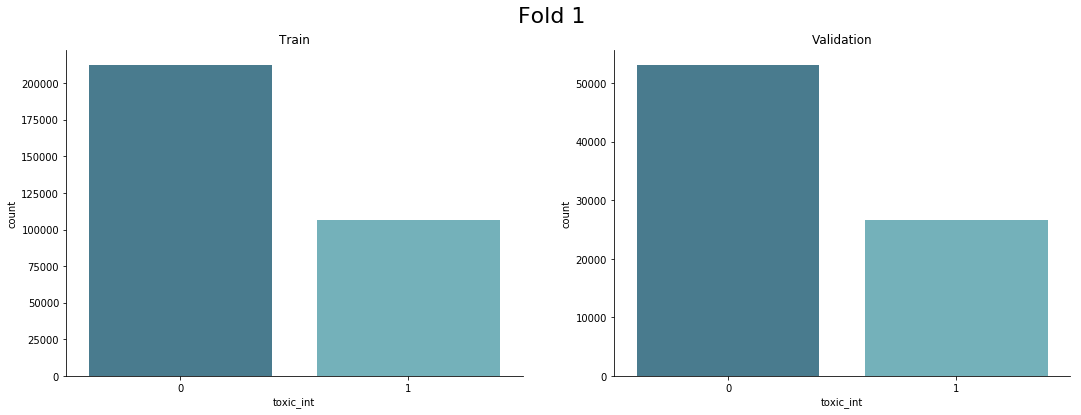

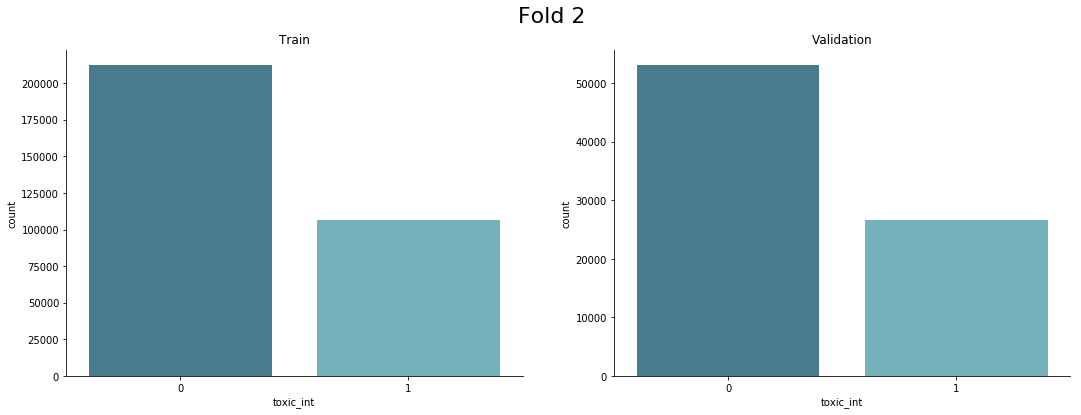

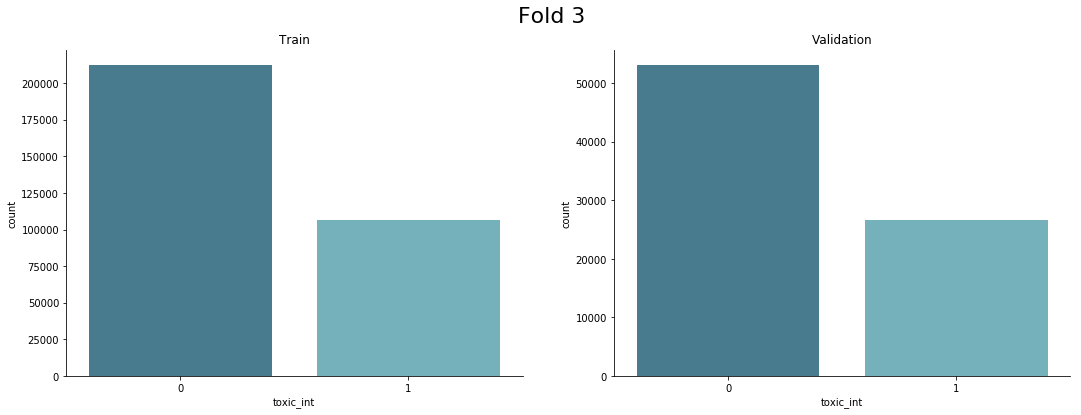

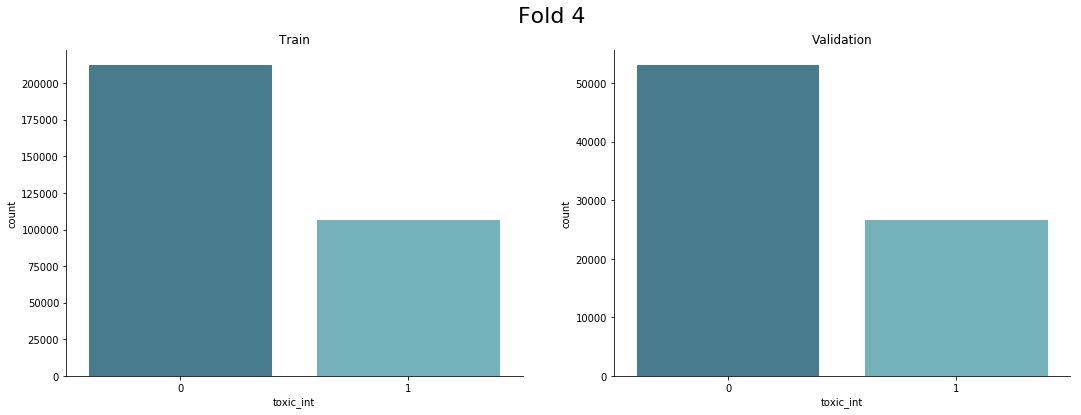

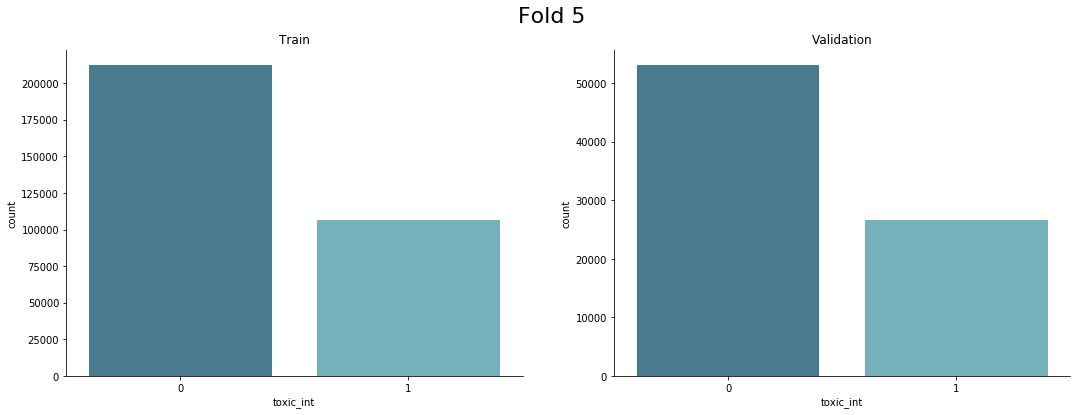

In [10]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

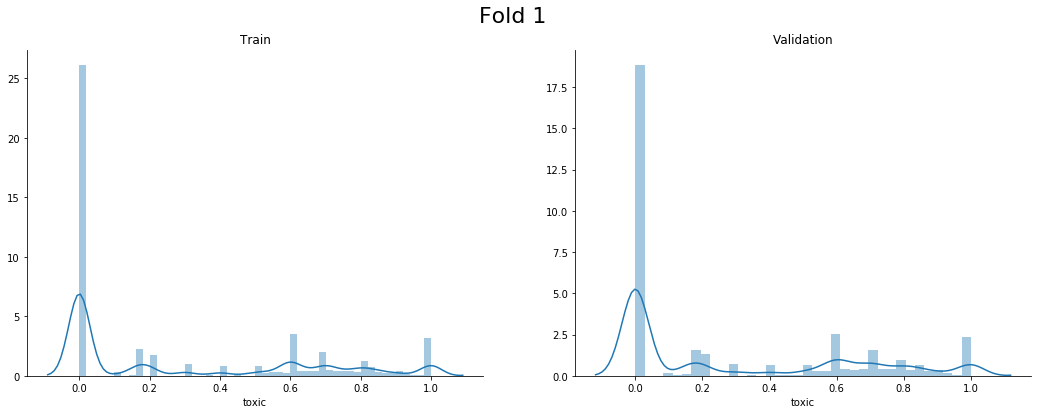

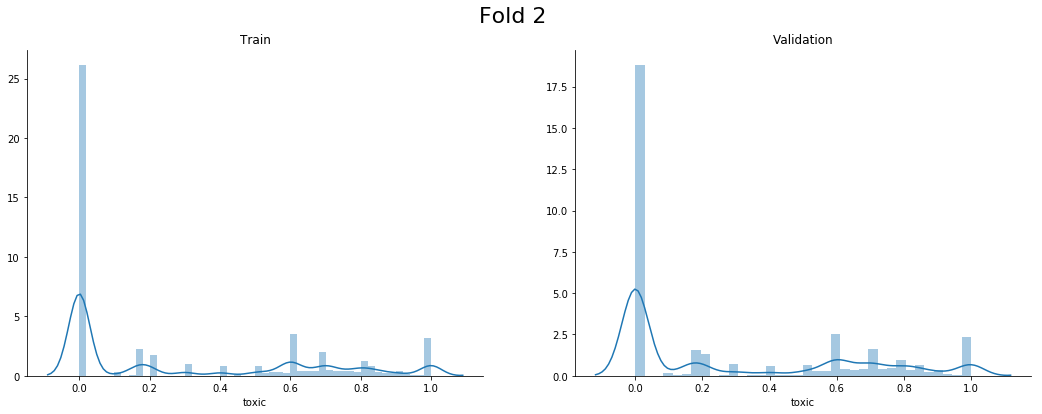

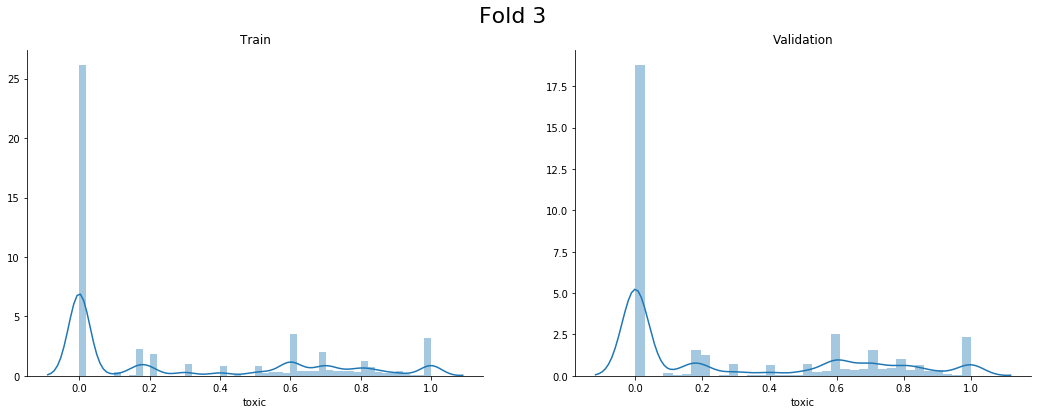

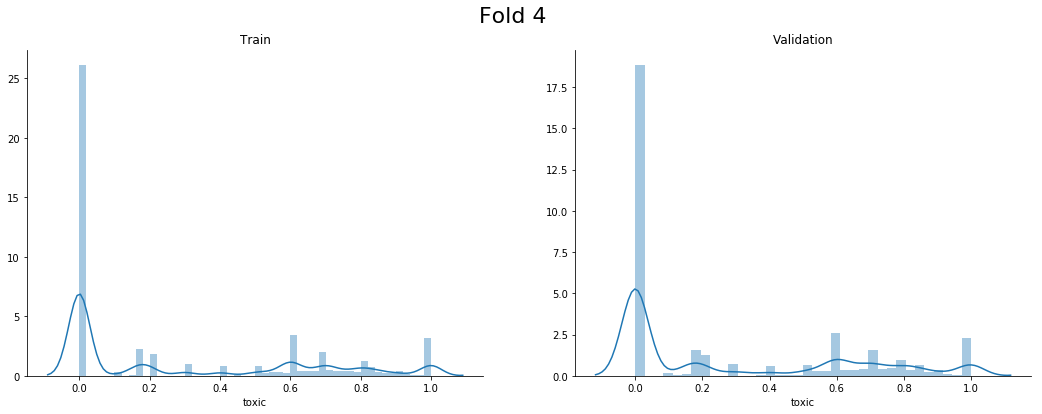

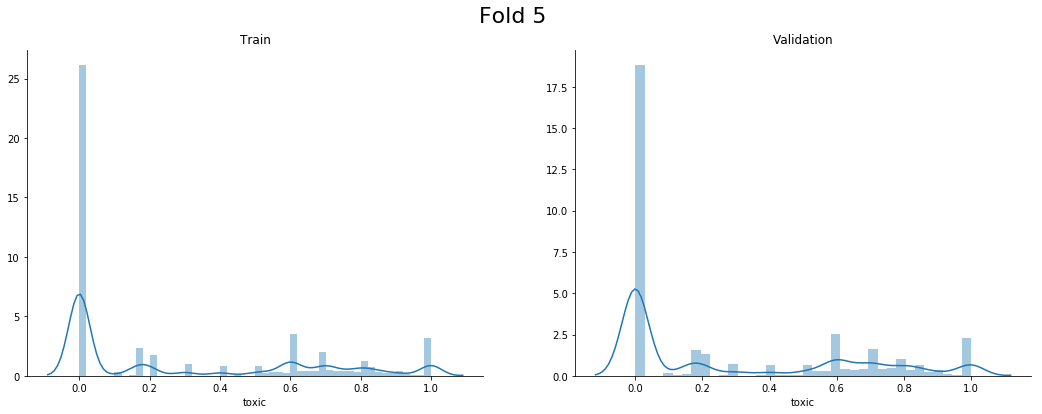

In [11]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['toxic'], ax=ax1).set_title('Train')
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['toxic'], ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [12]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    if fold_n < 1:
        fold_n += 1
        base_path = 'fold_%d/' % fold_n

        # Create dir
        os.makedirs(base_path)

        x_train, y_train = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        x_valid, y_valid = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        y_train_float, y_train_int = y_train
        y_valid_float, y_valid_int = y_valid
        x_train, y_train_float, y_train_int =  np.asarray(x_train), np.asarray(y_train_float), np.asarray(y_train_int)
        x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)
        
        np.save(base_path + 'x_train', x_train)
        np.save(base_path + 'y_train', y_train_float)
        np.save(base_path + 'y_train_int', y_train_int)
        np.save(base_path + 'x_valid', x_valid)
        np.save(base_path + 'y_valid', y_valid_float)
        np.save(base_path + 'y_valid_int', y_valid_int)

        print('\nFOLD: %d' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('y_train_float shape:', y_train_float.shape)
        print('y_train_int shape:', y_train_int.shape)
        print('x_valid shape:', x_valid.shape)
        print('y_valid_float shape:', y_valid_float.shape)
        print('y_valid_int shape:', y_valid_int.shape)
        
        #################### ENCODE TAIL ONLY ####################

        x_train, _ = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                              tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_valid, _ = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                              tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_train = np.asarray(x_train)
        x_valid = np.asarray(x_valid)
        
        np.save(base_path + 'x_train_tail', x_train)
        np.save(base_path + 'x_valid_tail', x_valid)

        print('\nFOLD: %d [TAIL]' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('x_valid shape:', x_valid.shape)

#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
# !tar -cvzf fold_2.tar.gz fold_2
# !tar -cvzf fold_3.tar.gz fold_3
# !tar -cvzf fold_4.tar.gz fold_4
# !tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
# shutil.rmtree('fold_2')
# shutil.rmtree('fold_3')
# shutil.rmtree('fold_4')
# shutil.rmtree('fold_5')

,comment_text,toxic,toxic_int,length,word_count,token_count,fold_1,fold_2,fold_3,fold_4,fold_5
0,If someone's 'short-circuiting' mentally speaking they do uncharacteristic things. I witnessed this with my Uncle Robert. Bob as everyone called him embezzl...,0.0,0,588,97,148,train,validation,train,train,train
1,Oh Willy!! You took his bait! Ignore trolls like that.,1.0,1,54,10,19,validation,train,train,train,train
2,"What are you talking about, and why do you have to do it anonymously? Do you have any source for your claim that union money is spent in the millions to inf...",0.0,0,177,34,40,train,validation,train,train,train
3,"Ohh, and Pennsylvania is down .% since in terms of manufacturing jobs, their losses have been much more gradual but without the recovery Michigan has seen.",0.0,0,155,26,35,train,train,train,validation,train
4,The consumer will end up paying more if this corporate tax passes. What will the State do with the money ? Waste the money on social programs that will do n...,0.0,0,341,62,71,validation,train,train,train,train



FOLD: 1
x_train shape: (2, 318680, 128)
y_train_float shape: (318680,)
y_train_int shape: (318680,)
x_valid shape: (2, 79670, 128)
y_valid_float shape: (79670,)
y_valid_int shape: (79670,)

FOLD: 1 [TAIL]
x_train shape: (2, 318680, 128)
x_valid shape: (2, 79670, 128)
fold_1/
fold_1/x_train.npy
fold_1/y_train.npy
fold_1/y_valid.npy
fold_1/x_train_tail.npy
fold_1/y_train_int.npy
fold_1/y_valid_int.npy
fold_1/x_valid.npy
fold_1/x_valid_tail.npy


# Validation set

In [13]:
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])
# Preprocess
valid_df['comment_text'] = valid_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid_df['length'] = valid_df['comment_text'].apply(lambda x : len(x))
valid_df['word_count'] = valid_df['comment_text'].apply(lambda x : len(x.split(' ')))
valid_df['token_count'] = valid_df['comment_text'].apply(lambda x : len(tokenizer.encode(x)))
display(valid_df.head())
display(valid_df.describe())

x_valid, y_valid = get_data_valid(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_valid, y_valid = np.asarray(x_valid), np.asarray(y_valid)

np.save('x_valid', x_valid)
np.save('y_valid', y_valid)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)

#################### ENCODE TAIL ONLY ####################

x_valid, _ = get_data_valid(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
x_valid =  np.asarray(x_valid)

np.save('x_valid_tail', np.asarray(x_valid))
print('[TAIL] x_valid shape:', x_valid.shape)

,comment_text,lang,toxic,length,word_count,token_count
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo media...,es,0,223,39,61
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, nel fare cio .",it,0,130,21,34
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder años a nivel particular. Las volveria a pasar putas.Fe...",es,1,162,26,43
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siyaset bilimi ana başlığından sonra siyasal ...,tr,0,391,49,94
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecekte(- yıl) bu tip şeyler düşünüyorum. Tab...,tr,0,412,54,102


,toxic,length,word_count,token_count
count,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.153750,359.099000,54.796500,92.410250
std,0.360731,265.423962,38.903098,65.118025
min,0.000000,0.000000,1.000000,2.000000
25%,0.000000,169.000000,27.000000,46.000000
50%,0.000000,269.500000,42.000000,71.000000
75%,0.000000,458.000000,69.250000,116.000000
max,1.000000,1623.000000,204.000000,860.000000


x_valid shape: (2, 8000, 128)
y_valid shape: (8000,)
[TAIL] x_valid shape: (2, 8000, 128)


# Test set

In [14]:
test_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv", usecols=['content'])
# Preprocess
test_df['content'] = test_df.apply(lambda x: clean_text(x['content']), axis=1)
test_df['length'] = test_df['content'].apply(lambda x : len(x))
test_df['word_count'] = test_df['content'].apply(lambda x : len(x.split(' ')))
test_df['token_count'] = test_df['content'].apply(lambda x : len(tokenizer.encode(x)))
display(test_df.head())
display(test_df.describe())

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_test = np.asarray(x_test)

np.save('x_test', x_test)
print('x_test shape:', x_test.shape)

#################### ENCODE TAIL ONLY ####################

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
x_test = np.asarray(x_test)

np.save('x_test_tail', x_test)
print('[TAIL] x_test shape:', x_test.shape)

,content,length,word_count,token_count
0,Doctor Who adlı viki başlığına . doctor olarak bir viki yazarı kendi adını eklemiştir. Şahsen düzelttim. Onaylarsanız sevinirim. Occipital,138,19,40
1,"Вполне возможно, но я пока не вижу необходимости выделять материал в отдельную статью. Если про правосудие в СССР будет написано хотя бы килобайт - — тогда ...",459,74,114
2,"Quindi tu sei uno di quelli conservativi , che preferiscono non cancellare. Ok. Avresti lasciato anche sfaccimma ? Si? Ok. Contento te... io non approvo per...",294,53,88
3,Malesef gerçekleştirilmedi ancak şöyle bir şey vardı. Belki yararlanırsınız. İyi çalışmalar. Kud yaz Teşekkür ederim. Abidenin maddesini de genişletmeyi düş...,620,83,156
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu :Resim:Seldabagcan.jpg resmini yüklediğiniz için teşekkürler. Ancak dosyanın tanım sayfasında içeriğin kimin t...,1482,169,328


,length,word_count,token_count
count,63812.000000,63812.000000,63812.000000
mean,369.238968,58.119163,97.366655
std,273.072290,41.626059,69.995128
min,0.000000,1.000000,2.000000
25%,169.000000,27.000000,48.000000
50%,276.000000,44.000000,75.000000
75%,481.000000,76.000000,125.000000
max,7794.000000,217.000000,3856.000000


x_test shape: (2, 63812, 128)
[TAIL] x_test shape: (2, 63812, 128)


# Test set EDA

## Word count distribution

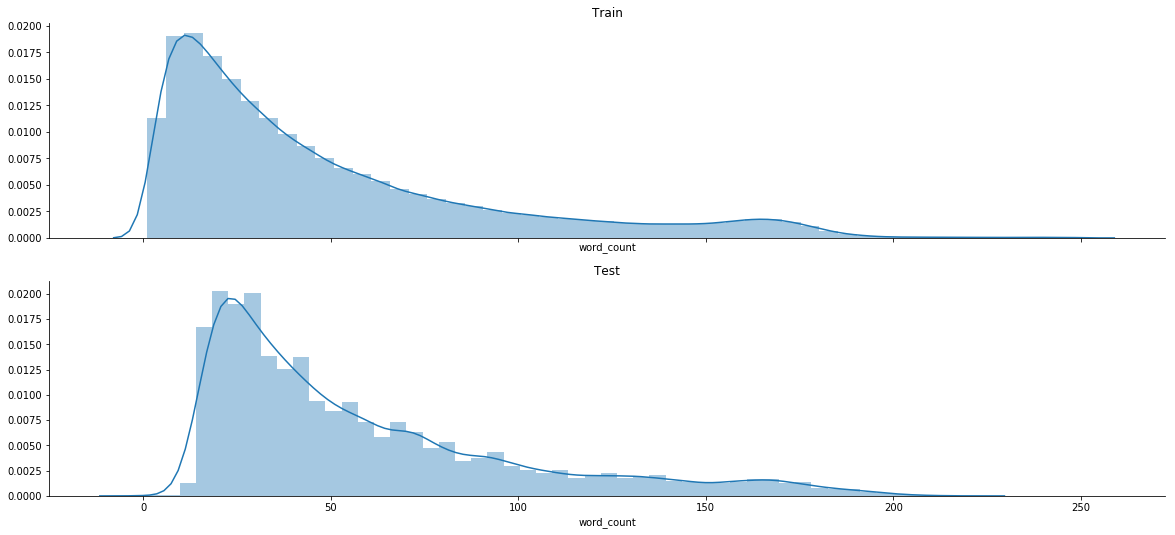

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['word_count'], ax=ax1).set_title("Train")
sns.distplot(test_df['word_count'], ax=ax2).set_title("Test")
sns.despine()
plt.show()

## Token count distribution

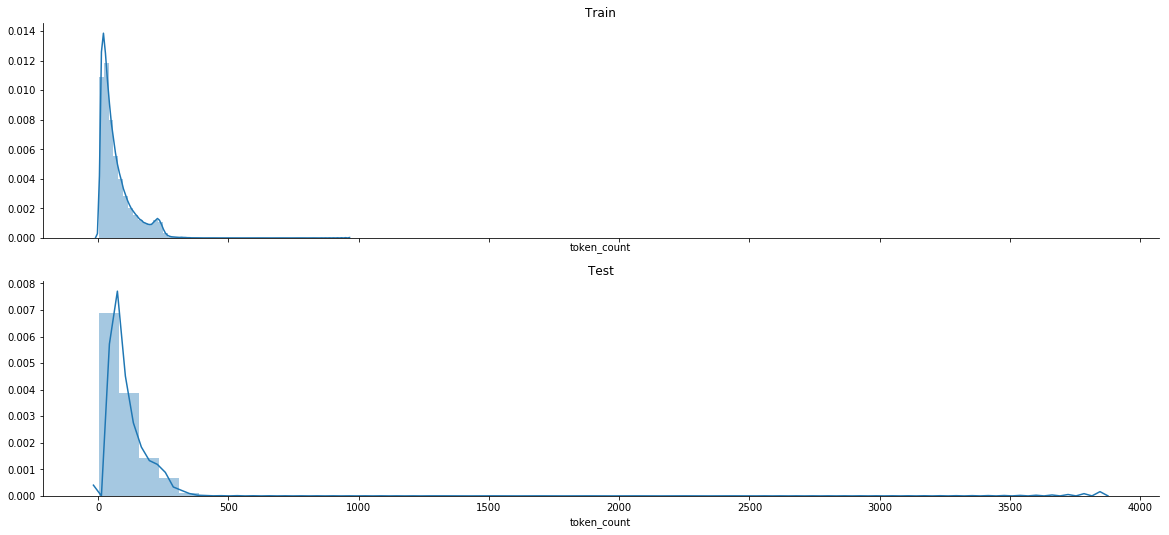

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['token_count'], ax=ax1).set_title("Train")
sns.distplot(test_df['token_count'], ax=ax2).set_title("Test")
sns.despine()
plt.show()